# PRACTICA TÉCNICA DE MINERÍA 
**Serie de tiempo**

# **Equipo: 10**
Integrantes



*   
1856652 Velázquez Montemayor Ofelia
*
1862149 Cruz Martínez Diego Adrian
*
1867216 Martínez Reyes Jose Miguel
*
1941488 García Ortega Jose Andrés

# **Técnica de minería: serie de Tiempo**

**Punto 1. Ejemplo**

# Bitcoin Price. Prediction by ARIMA

In [ ]:
# Import libraries
from google.colab import  files
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime
warnings.filterwarnings('ignore')
plt.style.use('seaborn-poster')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Data Exploration 

In [ ]:
# Load data
files.upload()
df = pd.read_csv('bitstampUSD_1-min_data_2012-01-01_to_2017-10-20.csv')
df.head()

In [ ]:
# Unix-time to 
df.Timestamp = pd.to_datetime(df.Timestamp, unit='s')

# Resampling to daily frequency
df.index = df.Timestamp
df = df.resample('D').mean()

# Resampling to monthly frequency
df_month = df.resample('M').mean()

# Resampling to annual frequency
df_year = df.resample('A-DEC').mean()

# Resampling to quarterly frequency
df_Q = df.resample('Q-DEC').mean()

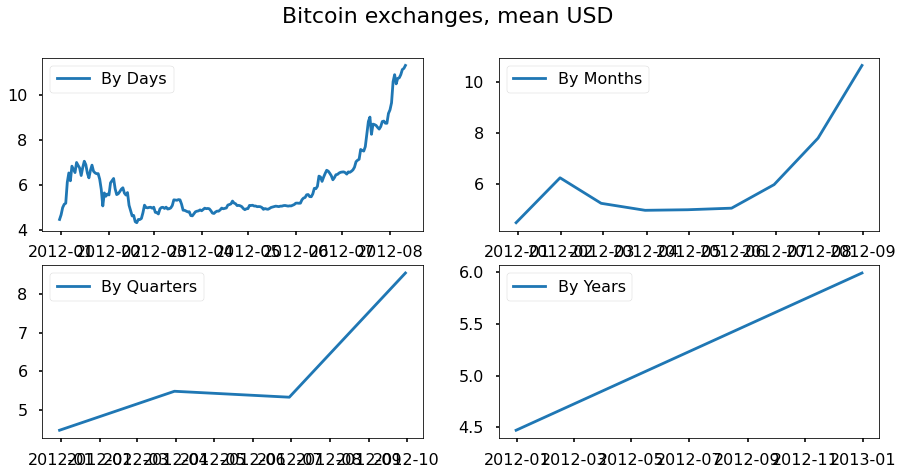

In [ ]:
# PLOTS
fig = plt.figure(figsize=[15, 7])
plt.suptitle('Bitcoin exchanges, mean USD', fontsize=22)

plt.subplot(221)
plt.plot(df.Weighted_Price, '-', label='By Days')
plt.legend()

plt.subplot(222)
plt.plot(df_month.Weighted_Price, '-', label='By Months')
plt.legend()

plt.subplot(223)
plt.plot(df_Q.Weighted_Price, '-', label='By Quarters')
plt.legend()

plt.subplot(224)
plt.plot(df_year.Weighted_Price, '-', label='By Years')
plt.legend()

# plt.tight_layout()
plt.show()

I will predict bitcoin prices by months.

Stationarity check and STL-decomposition of the series

In [ ]:
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(df_month.Weighted_Price).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Weighted_Price)[1])
plt.show()

The series are not stationary.

Box-Cox Transformations

In [ ]:
# Box-Cox Transformations
df_month['Weighted_Price_box'], lmbda = stats.boxcox(df_month.Weighted_Price)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Weighted_Price)[1])

The series are not stationary

Seasonal differentiation

In [ ]:
# Seasonal differentiation
df_month['prices_box_diff'] = df_month.Weighted_Price_box - df_month.Weighted_Price_box.shift(12)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff[12:])[1])

The series are not stationary.

Regular differentiation

In [ ]:
# Regular differentiation
df_month['prices_box_diff2'] = df_month.prices_box_diff - df_month.prices_box_diff.shift(1)
plt.figure(figsize=(15,7))

# STL-decomposition
sm.tsa.seasonal_decompose(df_month.prices_box_diff2[13:]).plot()   
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff2[13:])[1])

plt.show()

The series are stationary

Model Selection

In [ ]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df_month.prices_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df_month.prices_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plt.tight_layout()
plt.show()

In [ ]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(df_month.Weighted_Price_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [ ]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

Analysis of residues

In [ ]:
# STL-decomposition
plt.figure(figsize=(15,7))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

plt.tight_layout()
plt.show()

it's ok

Prediction

In [ ]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

In [ ]:
# Prediction
df_month2 = df_month[['Weighted_Price']]
date_list = [datetime(2017, 6, 30), datetime(2017, 7, 31), datetime(2017, 8, 31), datetime(2017, 9, 30), 
             datetime(2017, 10, 31), datetime(2017, 11, 30), datetime(2017, 12, 31), datetime(2018, 1, 31),
             datetime(2018, 1, 28)]
future = pd.DataFrame(index=date_list, columns= df_month.columns)
df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = invboxcox(best_model.predict(start=0, end=75), lmbda)
plt.figure(figsize=(15,7))
df_month2.Weighted_Price.plot()
df_month2.forecast.plot(color='r', ls='--', label='Predicted Weighted_Price')
plt.legend()
plt.title('Bitcoin exchanges, by months')
plt.ylabel('mean USD')
plt.show()

**Punto 2. BASE DE DATOS DEL PIA**

Utilizaremos el lenguaje de programación R para ello llamaremos a llamar la extensión de este

In [67]:
 %load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


Instalaremos las librerías necesarias y leemos la base de datos depurada

In [68]:
%%R
install.packages("tseries")
library(tseries)
base<-read.csv("covid3.csv")

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/tseries_0.10-48.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 170342 bytes (166 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[wr

Creamos de la base de datos el objeto serie de tiempo

In [69]:
%%R
serie<-ts(base$Personas_completamente_vacunadas_inter,start=c(2021,15),frequency=365,end=c(2021,280))

Graficando

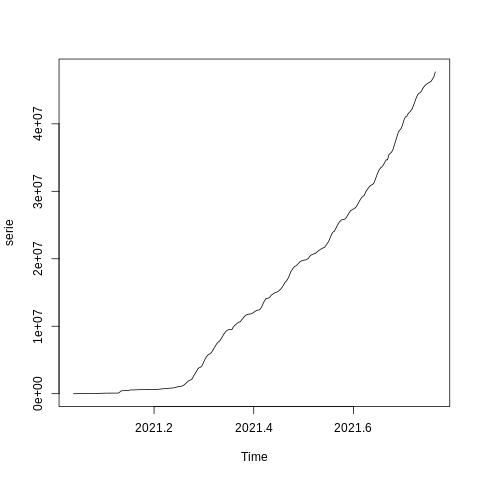

In [92]:
%%R
plot(serie)

**Primer paso: clasificar la serie de tiempo**

Para poder modelar necesitamos que la seria sea estacionaria y para ello debe de cumplir con dos requisitos 
Estacionariedad en media y varianza

**Estacionariedad en media**, es decir, que no muestre tendencia. Sin embargo se puede observar claramente que nuestra serie tiene tendencia, para corroborar aplicaremos un modelo lineal 

In [71]:
%%R
t<-as.numeric(time(serie))
regl<-lm(serie~t)
summary(regl) #p valor muy chico


Call:
lm(formula = serie ~ t)

Residuals:
     Min       1Q   Median       3Q      Max 
-4809409 -2919181 -1624452  2746006  8917375 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.352e+11  2.267e+09  -59.65   <2e-16 ***
t            6.691e+07  1.122e+06   59.66   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3848000 on 264 degrees of freedom
Multiple R-squared:  0.9309,	Adjusted R-squared:  0.9307 
F-statistic:  3559 on 1 and 264 DF,  p-value: < 2.2e-16



H0: muestra tendencia lineal


H1: no muestra tendencia lineal


Rechazamos H0 si p valor mayor a alfa, pero como p valor es muy chico, no rechazamos


Muestra evidencia de tendencia lineal



**Estacionariedad en varianza**

In [72]:
%%R
adf.test(serie,alternative="stationary")


	Augmented Dickey-Fuller Test

data:  serie
Dickey-Fuller = -1.0738, Lag order = 6, p-value = 0.9253
alternative hypothesis: stationary



H0: La serie no es estacionaria en varianza


H1: La serie es estacionaria en varianza

Rechazo H0 si p valor es menor que alfa, como p valor es mayor a alfa, no rechazo H0

La serie no es estacionaria en media ni en varianza

**Paso 2: corregir**

Para hacer la serie estacionaria aplicaremos diff y log puesto que no es estacionaria ni en media ni en varianza

In [73]:
%%R
i1<-diff(log(serie))

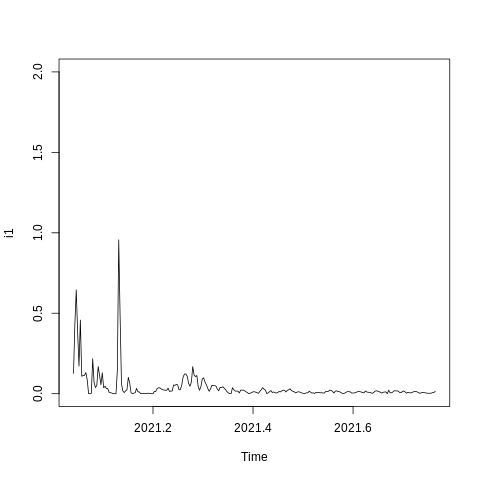

In [74]:
%%R
plot(i1,ylim=c(0,2))

Revisando estacionariedad en media

In [75]:
%%R
hi<-lm(i1~time(i1))
summary(hi)


Call:
lm(formula = i1 ~ time(i1))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.09318 -0.03157 -0.00900  0.01565  0.87299 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 335.81271   50.41509   6.661 1.58e-10 ***
time(i1)     -0.16611    0.02494  -6.660 1.59e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.08509 on 263 degrees of freedom
Multiple R-squared:  0.1443,	Adjusted R-squared:  0.1411 
F-statistic: 44.36 on 1 and 263 DF,  p-value: 1.59e-10



P valor muy chico, muestra tendencia lineal

**Segunda correción**

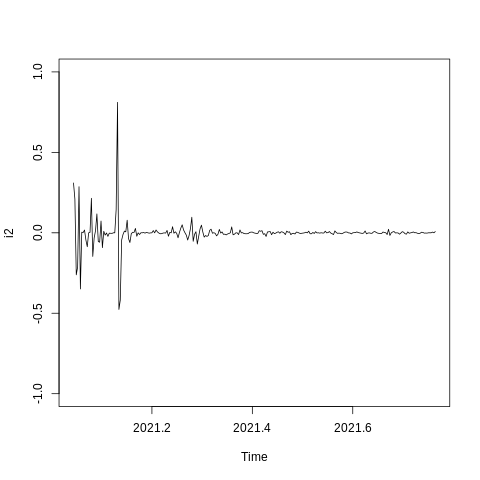

In [76]:
%%R
i2<-diff(i1)
plot(i2, ylim=c(-1,1))

Verificando corrección de media

In [77]:
%%R
summary(lm(i2~time(i2))) 


Call:
lm(formula = i2 ~ time(i2))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.47546 -0.00470 -0.00036  0.00483  0.81196 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept) -4.126093  48.110174  -0.086    0.932
time(i2)     0.002041   0.023800   0.086    0.932

Residual standard error: 0.08074 on 262 degrees of freedom
Multiple R-squared:  2.807e-05,	Adjusted R-squared:  -0.003789 
F-statistic: 0.007354 on 1 and 262 DF,  p-value: 0.9317



P valor alto, sin tendencia lineal

Verificando estacionariedad en varianza

In [78]:
%%R
adf.test(i2,alternative="stationary")


	Augmented Dickey-Fuller Test

data:  i2
Dickey-Fuller = -8.8939, Lag order = 6, p-value = 0.01
alternative hypothesis: stationary



Con una confianza del 89% podemos decir que la serie es estacionaria en varianza 

**Paso 3: Modelar**

In [79]:
%%R
aic.arma1<-Inf
orden.arma1<-c(0,0,0)
for(j in 0:10){
  for(i in 0:10){
    try(aic.xx1<-AIC(arima(i2,order=c(j,0,i),method ="ML" )))
    if(aic.arma1>aic.xx1){
      aic.arma1<-aic.xx1
      orden.arma1<-c(j,0,i)
    }
  }
}
aic.arma1
orden.arma1

[1] 3 0 4


El mejor modelo es un ARMA(3,4)

In [81]:
%%R
elegido.i2<-arima(i2,order=c(4,0,8), method="ML")
res48<-residuals(elegido.i2)

**Paso 4:Ruido blanco**

Media

In [82]:
%%R
mean(res48)

[1] -0.002704128


Varianza constante

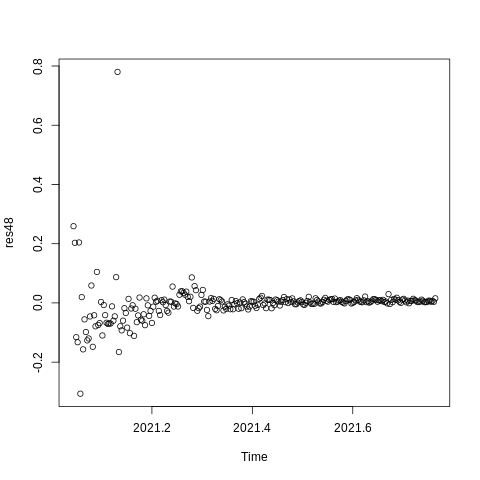

In [ ]:
%%R
plot(res48,type="p")

Con patron aparente, no cumple

Incorrelación

Gráficamente

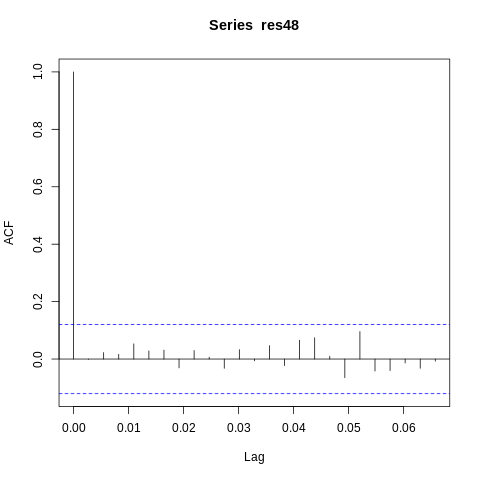

In [ ]:
%%R
acf(res48)

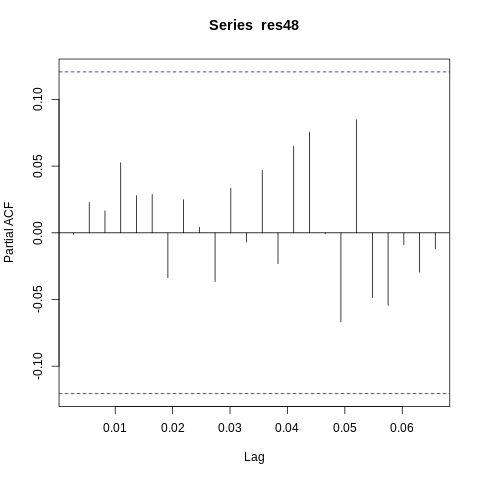

In [ ]:
%%R
pacf(res48)

Sobrepasa las lineas de confianza, de manera gráfica no cumple la incorrelación

Anliticamente

In [ ]:
%%R
Box.test(res48)


	Box-Pierce test

data:  res48
X-squared = 0.00028717, df = 1, p-value = 0.9865



H0: residuales independientes


H0: residuales dependientes


Rechazo H0 si p valor<alfa


0.98 > 0.05

Residuales independientes 

Cumple con ruido blanco

Normalidad

In [ ]:
%%R
shapiro.test(res48)


	Shapiro-Wilk normality test

data:  res48
W = 0.52092, p-value < 2.2e-16



H0 residuales provienen de una distribución normal

H1: residuales provienen de otra distribución


Rechazo H0 si p valor<alfa
2.2e-16 < 0.11


Rechazo H0, residuales SIN normalidad

**Paso 5:Predicciones**

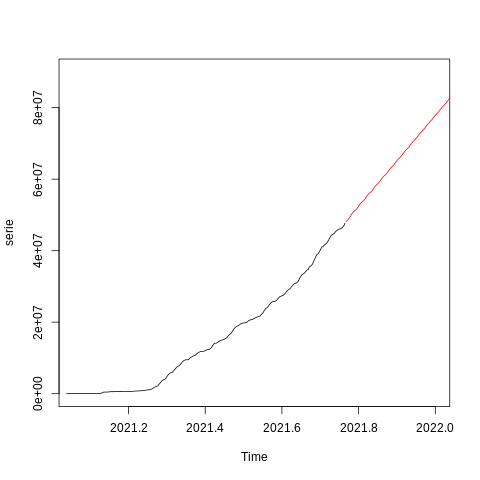

In [83]:
%%R
plot(serie, xlim=c(2021+15/265,2022), ylim=c(0,90000000))
pred<-predict(arima(serie,order=c(4,2,8),method="ML"),n.ahead=150)$pred
lines(pred,col="red")

In [84]:
%%R
poblacion<-131399538
vtr<-c(.4,.5,.6,.7)
p2<-vtr*poblacion

In [85]:
%%R
tail(serie,1)/poblacion *100

[1] 36.2957


para el dia 08 de octubre del 2021 se encuentra vacunada el 36.29% de la poblacion

In [86]:
%%R
dias<-c(0,0,0,0)
j=1
for (i in 1:150){
    if (pred[i]>=p2[j] & j<5 ){
        dias[j]<-i
        j=j+1
    }
}


In [87]:
%%R
f<-as.Date("2021-10-08")
f
message("\nSegun el modelo el 40% de la poblacion estara vacunada el ", f+dias[1])
message("\nSegun el modelo el 50% de la poblacion estara vacunada el ", f+dias[2])
message("\nSegun el modelo el 60% de la poblacion estara vacunada el ", f+dias[3])
message("\nSegun el modelo el 70% de la poblacion estara vacunada el ", f+dias[4])

R[write to console]: 
Segun el modelo el 40% de la poblacion estara vacunada el 2021-10-22

R[write to console]: 
Segun el modelo el 50% de la poblacion estara vacunada el 2021-11-29

R[write to console]: 
Segun el modelo el 60% de la poblacion estara vacunada el 2022-01-06

R[write to console]: 
Segun el modelo el 70% de la poblacion estara vacunada el 2022-02-12



##Metricas de Valuacion


Para revisar nuestras metricas utilizaremos los ultimos 20 dias registrados y los compararemos usando nuestro modelo con las predicciones que nos da para estos dias y con ello ver que tan bueno es el modelo.

In [107]:
%%R
serie_corta=serie[1:246]
pred_anteriores<-predict(arima(serie_corta,order=c(4,2,8),method="ML"),n.ahead=266-246)$pred
pred_anteriores


Time Series:
Start = 247 
End = 266 
Frequency = 1 
 [1] 41724856 41978082 42360847 42848634 43252766 43612104 43968400 44296170
 [9] 44668930 45073082 45494067 45907090 46285881 46638166 46984576 47350129
[17] 47745283 48158167 48566250 48951322


In [108]:
%%R
valores_reales = serie[247:266]
valores_reales

 [1] 41698947 41918336 42200082 42715579 43248659 43820430 44278675 44511000
 [9] 44626347 44902572 45284037 45572525 45794439 45924491 46054543 46182187
[17] 46309831 46648316 46986802 47692378


###Error absoluto medio

In [114]:
%%R
n=length(valores_reales)
suma=0
for (i in 1:n){
    suma= abs(pred_anteriores[i]-valores_reales[i])+suma
}
suma

MAE = 1/n *suma
MAE

[1] 548074.4


Este dato nos muestra en promedio cuanto puede llegar a differir los datos reales con respecto a nuestras preedicciones.

###Error cuadratico medio

In [124]:
%%R
n=length(valores_reales)
suma=0
for (i in 1:n){
    suma= ((pred_anteriores[i]-valores_reales[i])**2)+suma
}
suma

MSE = 1/n *suma
MSE

[1] 591011383012


###La raíz del error cuadrático medio

In [120]:
%%R
RMSE=sqrt(MSE)
RMSE

[1] 768772.6


Este dato nos muestra la dispersion de nuestros datos en el transcurso del tiempo, penalizando fuertemente los errores grandes. Por lo que la dispersion de nuestros datos es de 768,772

### Error porcentual absoluto

In [122]:
%%R
n=length(valores_reales)
suma=0
for (i in 1:n){
    suma= 100*abs((pred_anteriores[i]-valores_reales[i])/pred_anteriores[i])+suma
}
suma

MAPE = 1/n *suma
MAPE

[1] 1.162003


Para la evaluación del desempeño predictivo se emplean diferentes indicadores que cuantifican que tan cerca esta la variable pronosticada de su serie de datos correspondiente. Una de las medidas mas utilizadas es el Promedio
del Error Porcentual Absoluto. 
El MAPE mide el valor medio del error absoluto en terminos porcentuales al valor real de la variable

Podemos apreciar que en nuestro modelo tenemos un error promedio de 1.16% lo cual lo hace un modelo muy aceptable

###Métricas o coeficientes de precisión U de Theil

U1


In [126]:
%%R
n=length(valores_reales)
suma1=0
suma2=0
suma3=0
for (i in 1:n){
    suma1= (pred_anteriores[i]-valores_reales[i])**2+suma
    suma2 = (pred_anteriores[i]**2)+suma2
    suma3= (valores_reales[i]**2)+suma2
}


U1 = ((sqrt(1/n * suma1))/((sqrt(1/n * suma2))+ (sqrt(1/n*suma3))))
U1

[1] 0.008905546


Este coeficiente nos indica que cuanto mayor sea la precisión de la predicción, menor será el valor del coeficiente el cual esta dentro de un rango de (0,1).

Como vemos tenemos un coeficiente muy bajo lo cual nos indica que las predicciones que encuentra nuestro modelo parecen ser muy precisas